# 0. Importing packages

In [2]:
print("Importing packages")
import pandas as pd
import numpy as np
import uproot
import awkward as ak
import glob
from scipy.optimize import *
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
import pickle
import time
import random
from matplotlib import pyplot as plt


CPUs = 30 #cpu_count()
threshold = 80
lowEff = 0.05

Importing packages


# 1. Loading data

In [3]:
def calcL1MET(dataframe):
    
    """
    This function calculates the MET from the energy deposited on the trigger towers.
    """
    caloTowers = np.copy(dataframe)
   
    """ The second step is to convert the collider axes to radians and then calculate the x and y projections of energy deposits: """
    caloTowers[:,1] = caloTowers[:,1] * ((2*np.pi)/72)     # convert iphi into radians
    
    ietx = caloTowers[:,2] * np.cos(caloTowers[:,1].astype(float))    # calculate x component of energy for each tower
    iety = caloTowers[:,2] * np.sin(caloTowers[:,1].astype(float))    # calculate y component of energy for each tower
    
    caloTowers = np.c_[ caloTowers, ietx, iety ]
    caloTowers = pd.DataFrame(data=caloTowers[:, [3,4,5]], columns=["event", "ietx", "iety"])
    caloTowers = caloTowers.groupby(['event']).sum()
    caloTowers['caloMET'] = np.sqrt(caloTowers.ietx**2 + caloTowers.iety**2) /2               # calculate MET from metx and mety
    caloTowers = caloTowers.drop(['ietx', 'iety'], axis=1)                             # drop unrequired columns
    caloTowers = np.floor(caloTowers)                                                  # take floor to match firmware 
    
    return caloTowers.caloMET.astype("float64")

In [4]:
def compNTT4(caloTowers):

    df = caloTowers[(caloTowers["ieta"]>= -4) & (caloTowers["ieta"] <= 4)]
    df = df.drop(["ieta", "iphi"], axis=1)
    df = df.groupby(["event"]).count()
    df = df.rename(columns={"iet": "ntt4"})
    df["ntt4"] /= 5
    df["ntt4"] = df["ntt4"].round()
    df["ntt4"] = df["ntt4"].clip(upper=32)
    return df

In [5]:
def readPuppiData(data, subtractMu):
    assert subtractMu == True or subtractMu == False
    
    if subtractMu == True:
        print("Reading in PUPPI MET pT and phi")
        batches = [batch for batch in uproot.iterate(data, filter_name = ["PuppiMET_pt", "PuppiMET_phi"], library = "ak")]
        dat_ak = ak.concatenate(batches)
        dat = ak.to_dataframe(dat_ak)
        # Get x and y components of PUPPI MET
        print("Calculating x and y components of PUPPI MET")
        puppi_ptx, puppi_pty = np.cos(dat.PuppiMET_phi) * dat.PuppiMET_pt, np.sin(dat.PuppiMET_phi) * dat.PuppiMET_pt
    
        # Read muon pT data
        print("Reading in muon pT and phi")
        batches = [batch for batch in uproot.iterate(data, filter_name = ["Muon_phi", "Muon_pt", "Muon_isPFcand"], library = "ak")]
        dat_ak = ak.concatenate(batches)
        dat = ak.to_dataframe(dat_ak)
        # Create df of total muon ptx and pty for every event
        muon_dat = {
            "muon_ptx" : [],
            "muon_pty" : []
        }
        print("Calculating muon ptx and pty for each event")
        for ev in set(dat.index.get_level_values(0)):
            df = dat.xs(ev, level='entry')                 # Get data for every muon in event ev
            df = df[df["Muon_isPFcand"]==True]
            muon_ptx = np.cos(df.Muon_phi) * df.Muon_pt    # Calculate x component of pt of every muon in ev
            muon_pty = np.sin(df.Muon_phi) * df.Muon_pt    # Calculate y component of pt of every muon in ev
            
            muon_dat["muon_ptx"].append(muon_ptx.sum())    # Calculate total x pt of muons in ev and append to dict
            muon_dat["muon_pty"].append(muon_pty.sum())    # Calculate total x pt of muons in ev and append to dict
        
        print("Calculating PUPPI MET no Mu and reformatting data")
        muon_ptx_tot, muon_pty_tot = pd.Series(muon_dat["muon_ptx"]), pd.Series(muon_dat["muon_pty"])     # Convert data in dict to pandas series for computation with puppi pt series
        puppi_ptx_noMu, puppi_pty_noMu = puppi_ptx + muon_ptx_tot, puppi_pty + muon_pty_tot           # add muon pt to the met for both x and y componets
        puppi_METNoMu = np.sqrt((puppi_ptx_noMu)**2 + (puppi_pty_noMu)**2)      # add x and y components of met_noMu in quadrature to get overall puppi_metNoMu
        oMET = pd.DataFrame(puppi_METNoMu, columns=["puppi_MetNoMu"], index=puppi_METNoMu.index)
        oMET.index.name = None
        oMET = oMET.reset_index(names="event", inplace=False)
    
    else:
        print("Reading in PUPPI MET pT")
        offline_batches = [batch for batch in uproot.iterate(data, filter_name = "PuppiMET_pt", library = "pd")]
        oMET = pd.concat(offline_batches)
        event_col = oMET.index
        oMET.insert(loc = 0, column="event", value=event_col)
        
    return oMET

In [6]:
def readCaloData(data):
    
    print("Reading in calo tower data")
    calo_batches = [batch for batch in uproot.iterate(data, filter_name = ["L1EmulCaloTower_ieta", "L1EmulCaloTower_iet", "L1EmulCaloTower_iphi"], library = "ak")]
    calo_ak = ak.concatenate(calo_batches)
    calo = ak.to_dataframe(calo_ak)
    """ For calo data, create new "event" column from the index, set new index as  "event, eta and phi values", store this df in new variable """
    calo['event'] = calo.index.get_level_values(0)
    calo = calo.reset_index(inplace=False)
    calo = calo.drop(["entry", "subentry"], axis=1)
    # Rename columns
    calo = calo.rename(columns={
        "L1EmulCaloTower_ieta": "ieta",
        "L1EmulCaloTower_iphi": "iphi",
        "L1EmulCaloTower_iet" : "iet",
    })
    # Reorder columns
    calo = calo[["ieta", "iphi", "iet", "event"]]
    
    return calo

In [7]:
def cutMET(cuts, calo, oMET):

    offlineMET_quantity = oMET.columns[-1]
    onlineCut, offlineCut = cuts
    print("Cutting on online MET")
    
    """ Perform online cut first """
    L1MET = pd.DataFrame(calcL1MET(calo))
    events_in_range = list(L1MET[L1MET["caloMET"] > onlineCut ].index)
    calo = calo[calo["event"].isin(events_in_range)]
    oMET = oMET[oMET["event"].isin(events_in_range)]
    print("Cutting on offline MET")
    
    """ Perform offline cut """
    events_in_range = list( (oMET[oMET[offlineMET_quantity] < offlineCut ].index) )
    calo = calo[calo["event"].isin(events_in_range)]
    oMET = oMET[oMET["event"].isin(events_in_range)]  

    return calo, oMET

In [8]:
def flattenMET(calo, oMET, flat_params):

    print ("Flattening MET distribution")
    uniformMax, binWidth, nBinsUniform = flat_params   # uniformMax=125, binWidth=15, nBinsUniform=100
    if isinstance(oMET, pd.Series):
        oMET = pd.DataFrame(oMET)
        oMET = df.reset_index(drop=False).rename(columns={"index":"event"})
        
    offlineVar = oMET.columns[-1]
    n = int(len(oMET[oMET[offlineVar]>uniformMax]) - len(oMET[oMET[offlineVar]>uniformMax+binWidth]))*nBinsUniform  # Number of rows to select
    bins = np.linspace(0, uniformMax, num=20)
    oMET['binned'] = pd.cut(oMET[offlineVar], bins=bins, labels=False)
    selected_rows = []
    for i in range(n):
        bin_rows = oMET[oMET['binned'] == i%20]
        if len(bin_rows) > 0:
            random_row = bin_rows.sample(1)
            selected_rows.append(random_row)
            oMET = oMET.drop(random_row.index)
    selected_rows = pd.concat(selected_rows)
    remaining_rows = oMET[oMET[offlineVar] > uniformMax]
    selected_rows = pd.concat([selected_rows, remaining_rows])
    
    print ('N towers, offline MET before : ', len(calo))
    calo = calo[calo["event"].isin(selected_rows)]
    oMET = oMET[oMET["event"].isin(selected_rows)]
    print ('N towers, offline MET after : ', len(calo))
    
    return calo, oMET

In [9]:
def subsetEvents(calo, oMET, subset):
    print("Subsetting events")
    offlineMET_quantity = oMET.columns[-1]
    events = np.array(oMET.event)    # events is a list of all the event indices which survived the cut, so event indices 0 to 10,000, and the list is ~ 8318 long
    num_of_fit_events = int( np.ceil(len(oMET) * subset) )
    fit_event_indices = np.array( random.sample(range(len(events)), num_of_fit_events) ).astype(int)   # Randomly select num_of_fit_events in the range 0 - 8318, these will be the indices of the fit events. Then the rest of indices in this range are assigned for validation:
    valid_event_indices = np.array( list(set(range(len(oMET.event))) - set(fit_event_indices)) ).astype(int)     # indices between 0-8318 which can be used to index events list, to get the events which will be used in gs
    
    fit_events, valid_events = events[fit_event_indices], events[valid_event_indices]
    fit_calo_events, fit_pfMET_events = calo[calo["event"].isin(fit_events)], oMET[oMET["event"].isin(fit_events)][offlineMET_quantity].astype("float64")
    valid_calo_events, valid_pfMET_events = calo[calo["event"].isin(valid_events)], oMET[oMET["event"].isin(valid_events)][offlineMET_quantity].astype("float64")

    return (fit_calo_events, fit_pfMET_events), (valid_calo_events, valid_pfMET_events)

In [10]:
def prepareInputs(dir, subset=1, cuts=(0, 0), flatten=False, subtractMuon=True, prop=1):

    # Get a list of files
    random.seed(42)
    filesInDir = glob.glob(dir)
    fileNames = random.sample(
        filesInDir,
        int(np.ceil( prop * len(filesInDir)) )
    )
    data = ["{fileName}:{tree}".format(fileName = f, tree = "Events;1") for f in fileNames]

    # Read in offline and online data
    calo = readCaloData(data = data)
    oMET = readPuppiData(data = data, subtractMu = subtractMuon)
    
    # Cut MET online and offline based on cuts argument
    if (cuts[0] != 0) and (cuts[1] != 0):
        calo, oMET = cutMET(cuts = cuts, calo = calo, oMET = oMET)

    # Flatten MET distribution at low MET to increase emphasis on higher MET region
    if flatten != False:
        calo, oMET = flattenMET(calo = calo, oMET = oMET, flat_params = flatten)

    # Subset events into fitting and testing samples
    fit_events, valid_events = subsetEvents(calo=calo, oMET=oMET, subset=subset)
    
    # Calculate NTT4
    print("Calculating NTT4")
    fit_calo_events, valid_calo_events = fit_events[0], valid_events[0]
    compntt_fit, compntt_valid = compNTT4(fit_calo_events), compNTT4(valid_calo_events)

    # Package and return data
    fit_data = (fit_events[0], fit_events[1], compntt_fit)
    valid_data = (valid_events[0], valid_events[1], compntt_valid)
    
    return fit_data, valid_data

# 2. Graphing METS

In [16]:
def plotHisto(METs, binning=np.linspace(0, 200, 101)):
    plt.figure(figsize=(14,8))
    for MET in METs:
        lab, dat = MET
        plt.hist(dat, bins=binning, histtype="step", label=lab)
    plt.xlabel("MET (GeV)")
    plt.title("MET distributions")
    plt.grid()
    plt.legend()

In [388]:
df = pd.DataFrame(puppiOld)

In [389]:
df = df.reset_index(drop=False).rename(columns={"index":"event"})

In [390]:
uniformMax=80
binWidth=15
nBinsUniform=100

offlineVar = "puppi_MetNoMu"

n = int(
    len(df[df[offlineVar]>uniformMax]) - len(df[df[offlineVar]>uniformMax+binWidth])    # Number of events with puppi MET between uniform max and uniformmax + bin width
) * nBinsUniform  # Number of rows to select

In [391]:
bins = np.linspace(0, uniformMax, num=20)
df['binned'] = pd.cut(df[offlineVar], bins=bins, labels=False)

In [392]:
selected_rows = []
for i in range(n):
    fives = [0.,5.,10.,15.,20.,25.,30.,35.,40.,45.,50.,55.,60.,65.,70.,75.,80.,85.,90.,95.,100.]
    progress = np.round((i/n)*100, 1)
    progress2=None
    if (progress in fives) and (progress!=progress2):
        progress2 = progress
        print("{}%".format(progress))
        
    bin_rows = df[df['binned'] == i%20]
    if len(bin_rows) > 0:
        random_row = bin_rows.sample(1)
        selected_rows.append(random_row)
        df = df.drop(random_row.index)

0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%
0.0%


KeyboardInterrupt: 

In [ ]:
selected_rows = pd.concat(selected_rows)
remaining_rows = df[df[offlineVar] > uniformMax]
selected_rows = pd.concat([selected_rows,remaining_rows])

In [ ]:
print ('N event (offline MET) before : ',len(df))
oMET = selected_rows
calo = calo[calo["event"].isin(oMET.index)]
print ('N event (offline MET) after : ',len(oMET))

In [ ]:
oMET

In [ ]:
plotHisto(
    [("Flattened PUPPI MET no mu", oMET["puppi_MetNoMu"]) ]
)

# 3. Applying thresholds

In [11]:
def towerEtThreshold(ieta, ntt4, a, b, c, d):
    
    pu = ntt4.copy()
    towerAreas = [    0., # dummy for ieta=0
                  1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,
                  1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,
                  1.03,1.15,1.3,1.48,1.72,2.05,1.72,4.02,
                  0., # dummy for ieta=29
                  3.29,2.01,2.02,2.01,2.02,2.0,2.03,1.99,2.02,2.04,2.00,3.47]
    
    term1 = float(towerAreas[int(abs(ieta))] ** a)
    term2 = 1 / ( d * (1 + np.exp(-b * (abs(ieta)))) )
    term3 = pu["ntt4"] ** c
    
    pu.rename(columns={"ntt4": "threshold"})
    
    pu["threshold"] = (term1 * term2 * term3).clip(upper=40)    # Rounding makes big difference to low Et towers as 0.6 --> 1.0 thus 0.5GeV towers no longer pass.
    
    return pu["threshold"].to_dict()    # Returns a vector - a threshold for every event because there's a compNTT4 value for every event

In [12]:
def applyThresholds(data, thresholds):  
    iets = np.array(data[:,0])
    thresholds = np.array([thresholds[event] for event in data[:,1]])
    comparison_list = iets > thresholds
    return comparison_list

In [13]:
def applyCaloTowerThresh(caloTowers, a, b, c, d):
    
    caloTowersPUsup = caloTowers.copy()
    compntt = compNTT4(caloTowersPUsup)
    MET = np.empty((0, 4))
    ietas = np.unique(caloTowersPUsup["ieta"][caloTowersPUsup["ieta"] != 0])    # Create unique list of all eta
    
    def process_ieta(ieta):
        towers = caloTowersPUsup[caloTowersPUsup["ieta"] == ieta].to_numpy()    # Convert pandas dataframe to numpy array
        thresholds = towerEtThreshold(ieta, compntt, a, b, c, d)    # Does compntt need to be calculated in the function so calculated for every thread?
        passed_tows = applyThresholds(towers[:, [2,3]], thresholds )
        towers[:,2] = towers[:,2].astype(float) * passed_tows
        return towers

    num_processes = CPUs #cpu_count()
    with ThreadPool(num_processes) as pool:
        towers_list = pool.map(process_ieta, ietas)
    
    MET = np.concatenate(towers_list)
    
    return calcL1MET(MET), MET.astype(int)

# 4. Optimisation

In [19]:
print("Loading data")
data = "/shared/scratch/wq22321/zmu_2023_data/*.root"
fitOld, validOld = prepareInputsOld(dir = data, subset=0.7, cuts=(0, 250), prop = 0.5)

Loading data
Reading PUPPI MET
Reading calo data
Subsetting events
Calculating NTT4


In [246]:
caloOld, puppiOld, ntt4Old = fitOld

In [22]:
def objective(params, turn_on = False):
    a, b, c, d = params
    print("\nCurrently trying: a = {}, b = {}, c = {} and d = {}".format(np.round(a,2), np.round(b,2), np.round(c,2), np.round(d,2)))
    MET, _ = applyCaloTowerThresh(calo, a, b, c, d)
    
    if turn_on == True:
        offline_bins = np.linspace(0, 300, 60)
        eff_0p05 = 0
        foundEff0p05 = False
        eff_0p95 = 99999
        eff_before = 0
        x_cross_95 = 99999
        x_cross_05 = 0
        eff_0p5 = 0
        foundEff0p5 = False
        for i in range(len(offline_bins) - 1):
            offline_range = (puppi >= offline_bins[i]) & (puppi < offline_bins[i + 1])
            num_offline = sum(offline_range)
            num_both = sum((MET > threshold) & offline_range)
            if num_offline > 0:
                eff = num_both / num_offline
            else:
                eff = 0
            # print (i,offline_bins[i],eff,num_offline,num_both)
            if eff >= lowEff and not foundEff0p05 :
                eff_0p05 = offline_bins[i]
                if (i>0):
                    x_cross_05 = offline_bins[i-1] + ((lowEff - eff_before) / (eff - eff_before)) * (eff_0p05 - offline_bins[i-1])
                else : x_cross_05 = eff_0p05
                foundEff0p05 = True
    
            if eff >= 0.5 and not foundEff0p5:
                eff_0p5 = offline_bins[i]
                foundEff0p5 = True
            if eff >= 0.95 :
                eff_0p95 = offline_bins[i]
                x_cross_95 = offline_bins[i-1] + ((0.95 - eff_before) / (eff - eff_before)) * (eff_0p95 - offline_bins[i-1])
                break
    
            eff_before = eff
        #print (a, b, c, d, eff_0p05, eff_0p5, eff_0p95, eff_0p95-eff_0p05, x_cross_05, x_cross_95, x_cross_95-x_cross_05)
        # return (eff_0p95-eff_0p05)
        print("Turn on width: {}".format(np.round(x_cross_95 - x_cross_05, 2)))
        return(x_cross_95-x_cross_05)
    
    else:
        difference = MET - puppi
        sqrd_diff = np.sum(difference**2)
        print("Squared difference = {}".format(np.round(sqrd_diff,2)))
        return sqrd_diff

In [ ]:
print("Starting optimisation")

bounds = [(0, 4), (0, 4), (0, 4), (0, 4)]
x0 = (2.0, 2.0, 0.5, 2.0)
result = differential_evolution(
    func     = objective,
    bounds   = bounds,
    popsize  = 40,
    maxiter  = 100,
    strategy = "best1bin",
    #init     = "sobol",
    disp     = True,
    workers  = 2,
    polish   = False
)

print(result.x)
print(result)

Starting optimisation

Currently trying: a = 1.31, b = 1.31, c = 0.73 and d = 3.36
Currently trying: a = 2.29, b = 2.01, c = 3.93 and d = 1.46

Squared difference = 23930964.19

Currently trying: a = 2.52, b = 3.19, c = 0.03 and d = 1.22
Squared difference = 53734646.86

Currently trying: a = 0.68, b = 2.14, c = 2.01 and d = 1.34
Squared difference = 22626931.14

Currently trying: a = 3.8, b = 0.86, c = 1.76 and d = 0.15
Squared difference = 53725776.84

Currently trying: a = 2.83, b = 2.17, c = 0.28 and d = 2.74
Squared difference = 53734646.86

Currently trying: a = 1.9, b = 0.37, c = 3.12 and d = 3.51
Squared difference = 22703749.85

Currently trying: a = 1.47, b = 2.94, c = 1.64 and d = 1.81
Squared difference = 53734646.86

Currently trying: a = 0.32, b = 0.19, c = 0.4 and d = 0.44
Squared difference = 52709694.52

Currently trying: a = 2.88, b = 0.99, c = 0.18 and d = 1.42
Squared difference = 29286154.98

Currently trying: a = 2.68, b = 2.74, c = 2.42 and d = 0.01
Squared diffe

# 5. Parameter analysis

In [14]:
def heatmapper(a, b, c, d):
    dat = lookup_gen(a, b, c, d)
    ietas, pu_bins, thresh = zip(*dat)
    plt.figure(figsize=(15,9))
    plt.hist2d(ietas, pu_bins, weights=thresh, bins=[83, 32])
    plt.colorbar()
    #plt.xlim([1,41]); plt.ylim([0,31])
    plt.xlabel("ieta"); plt.ylabel("NTT4 bin")
    plt.title("2D histogram of tower threshold (scaled by tower size)")
    plt.show()

In [15]:
def lookup_gen(a, b, c, d):
    
    all_ieta_vals = np.linspace(-41, 41, 83)
    all_pu_bins = np.linspace(0, 31, 32)
    
    res = []
    for ieta in all_ieta_vals:
        for pu_bin in all_pu_bins:
            thresh = threshold_calc(ieta, pu_bin, a, b, c, d)
            res.append((ieta, pu_bin, thresh))
            
    return res

In [16]:
def threshold_calc(ieta, ntt4, a, b, c, d):
    towerAreas = [    0., # dummy for ieta=0
                  1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,
                  1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,
                  1.03,1.15,1.3,1.48,1.72,2.05,1.72,4.02,
                  0., # dummy for ieta=29
                  3.29,2.01,2.02,2.01,2.02,2.0,2.03,1.99,2.02,2.04,2.00,3.47]
    
    numerator = (towerAreas[int(abs(ieta))]**a) * (ntt4**c)
    denominator = d * (1 + np.exp(-b * (abs(ieta))))
    
    threshold = (numerator / denominator).clip(max=40)
#    return (threshold/2)# / towerAreas[int(abs(ieta))]
    if towerAreas[int(abs(ieta))] == 0:
        return np.nan
    else:
        return (threshold/2)# / towerAreas[int(abs(ieta))]

In [20]:
fw = (0.66881105, 1.77791976, 0.96226907, 2.08912586)
reg = (0.21456065, 2.74961211, 0.47896413, 0.30650943)
old = (1.707, 3.078, 0.195, 1.365)

zmu23_1 = (1.87, 1.34, 0.1, 2.84)
zmu23_2 = (1.49, 2.91, 0.26, 1.51)
zmu23_3 = (2.34, 2.82, 0.37, 2.79)

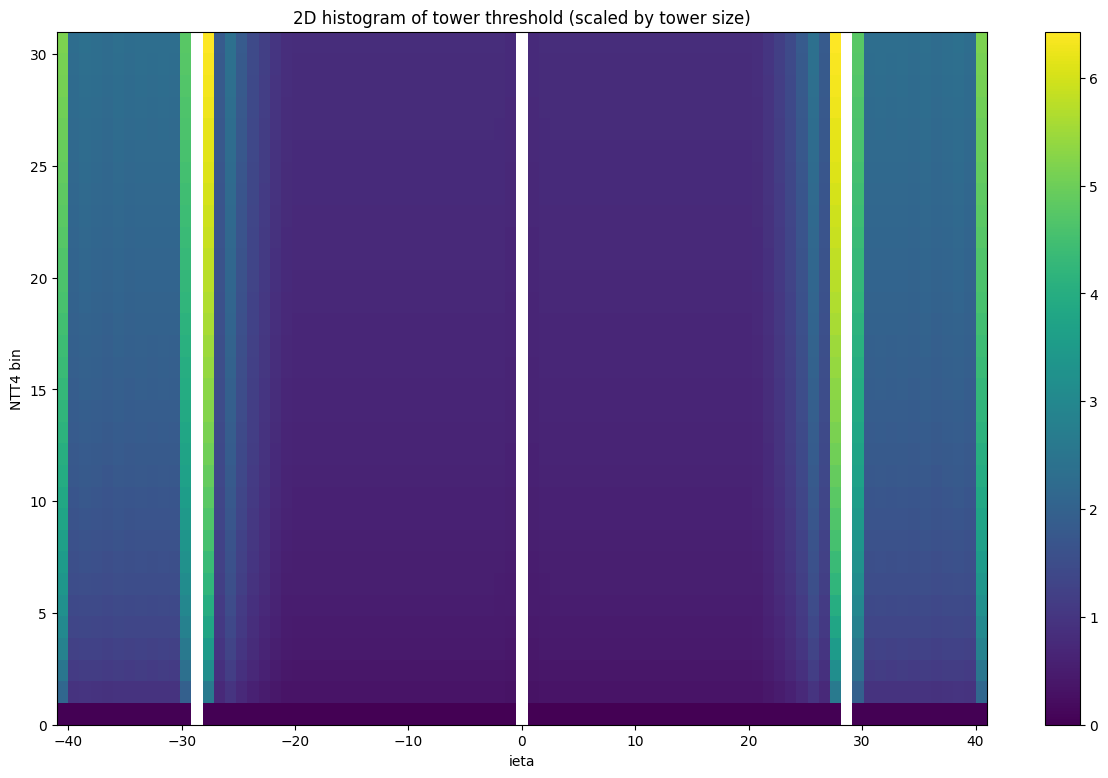

In [37]:
heatmapper(*zmu23_2)

In [23]:
valid_calo, valid_puppi, valid_ntt4 = validOld

In [32]:
MET = applyCaloTowerThresh(valid_calo, *zmu23_2)[0]

In [33]:
l1met = calcL1MET(valid_calo)

In [28]:
def getTurnOn( online, offline, threshold=80 ) :
    offline_bins = np.linspace(0, 300, 40)
    efficiency = []


    for i in range(len(offline_bins) - 1):
        # Define the offline range for this bin
        offline_range = (offline >= offline_bins[i]) & (offline < offline_bins[i + 1])
        # count the number of events passing the threshold in the offline range
        num_offline = sum(offline_range)
        # count the number of events passing the threshold in both online and offline ranges
        num_both = sum((online > threshold) & offline_range)
        # calculate the efficiency as the ratio of online events passing the cut over offline events passing the threshold
        if num_offline > 0:
            eff = num_both / num_offline
        else:
            eff = 0
        efficiency.append(eff)

    bin_centers = (offline_bins[:-1] + offline_bins[1:]) / 2

    return bin_centers, efficiency

In [34]:
bins, turnon = getTurnOn(MET, valid_puppi)

In [35]:
_, turnon_noPU = getTurnOn(l1met, valid_puppi)

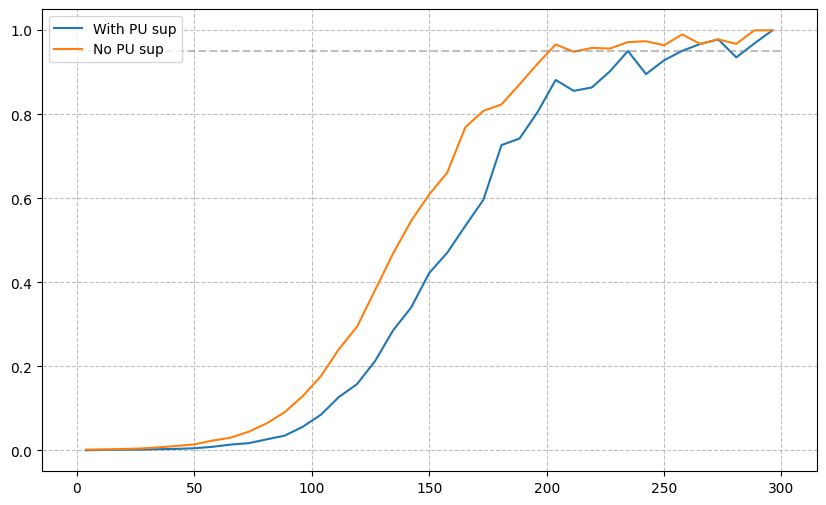

In [36]:
plt.figure(figsize=(10,6))

plt.plot(bins, turnon, label="With PU sup")
plt.plot(_, turnon_noPU, label = "No PU sup")

plt.grid(True, linestyle='--', color='gray', alpha=0.5)
plt.hlines(0.95, xmin=0, xmax=300, colors='gray', linestyles='--', alpha=0.5)
plt.legend()
plt.show()

# Reading old data

In [17]:
def readPuppiDataOld(files):
    offTree = "l1JetRecoTree/JetRecoTree"
    offlineDat = ["{fileName}:{tree}".format(fileName = f, tree = offTree) for f in files]

    offline_batches = [batch for batch in uproot.iterate(offlineDat, filter_name = "pfMetNoMu", library = "pd")]
    df_oMET = pd.concat(offline_batches)

    df_oMET = df_oMET.reset_index()
    df_oMET = df_oMET.rename(columns={"pfMetNoMu" : "puppi_MetNoMu", "index" : "event"})

    return df_oMET

def readCaloDataOld(files):
    caloTree = "l1CaloTowerEmuTree/L1CaloTowerTree"
    calofiles = ["{fileName}:{tree}".format(fileName = f, tree = caloTree) for f in files]

    calo_batches = [batch for batch in uproot.iterate(calofiles, filter_name = ["ieta", "iet", "iphi"], library = "ak")]
    df_calo_ak = ak.concatenate(calo_batches)
    df_calo = ak.to_dataframe(df_calo_ak)

    df_calo_met = df_calo
    df_calo_met['event'] = df_calo_met.index.get_level_values(0)
    df_calo_met = df_calo_met.reset_index(inplace=False)
    df_calo_met = df_calo_met.drop(["entry", "subentry"], axis=1)

    return df_calo_met


def prepareInputsOld(dir, subset=1, cuts=(0, 0), flatten=False, prop=1):

    random.seed(42)
    filesInDir = glob.glob(dir)
    fileNames = random.sample(
        filesInDir,
        int(np.ceil( prop * len(filesInDir)) )
    )

    print("Reading PUPPI MET")
    oMET = readPuppiDataOld(fileNames)
    print("Reading calo data")
    calo = readCaloDataOld(fileNames)
    
    # Cut MET online and offline based on cuts argument
    if (cuts[0] != 0) and (cuts[1] != 0):
        calo, oMET = cutMET(cuts = cuts, calo = calo, oMET = oMET)

    # Flatten MET distribution at low MET to increase emphasis on higher MET region
    if flatten != False:
        calo, oMET = flattenMET(calo = calo, oMET = oMET, flat_params=flatten)

    # Subset events into fitting and testing samples
    fit_events, valid_events = subsetEvents(calo=calo, oMET=oMET, subset=subset)
    
    # Calculate NTT4
    print("Calculating NTT4")
    fit_calo_events, valid_calo_events = fit_events[0], valid_events[0]
    compntt_fit, compntt_valid = compNTT4(fit_calo_events), compNTT4(valid_calo_events)

    # Package and return data
    fit_data = (fit_events[0], fit_events[1], compntt_fit)
    valid_data = (valid_events[0], valid_events[1], compntt_valid)
    
    return fit_data, valid_data